In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde 
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import read

In [2]:
from dscribe.descriptors import CoulombMatrix, SOAP, MBTR

In [3]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split,learning_curve
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

## Step 0: Problem

In this short tutorial we will test the atomistic representation to predict the properties of molecules

We want to test the Coulomb matrix, MBTR and SOAP descriptors to predict the HOMO-LUMO gap

Since it is a continuous property that we have a dataset with calculated target values we will a supervised learning regression task

## Step 1: Data

For practical reasons, the [GDB-9 dataset](https://doi.org/10.6084/m9.figshare.978904_D12) was screened for molecules with up to 7 heavy atoms, resulting in 3982 molecules. For each molecule we have the HOMO-LUMO gap and atomistic structure, among other properties.

We will first read the data, view the properties available and prepare the dataset for computing the descriptors.

It is important to gain familiarity with the data

In [4]:
qmdb_df = pd.read_pickle('gdb-7_df.p')

In [5]:
qmdb_df.shape[0]

3982

In [6]:
qmdb_df.columns

Index(['formula', 'tag', 'natoms', 'natoms_heavy', 'nkinds',
       'rotational_constant_A', 'rotational_constant_B',
       'rotational_constant_C', 'dipole_moment', 'isotropic_polarizability',
       'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv',
       'frequencies', 'SMILES', 'InChI', 'ase_atoms'],
      dtype='object')

In [7]:
qmdb_df.head()

,formula,tag,natoms,natoms_heavy,nkinds,rotational_constant_A,rotational_constant_B,rotational_constant_C,dipole_moment,isotropic_polarizability,...,zpve,U0,U,H,G,Cv,frequencies,SMILES,InChI,ase_atoms
index,,,,,,,,,,,,,,,,,,,,,
594,C4H8O2,gdb,14,6,3,12.94847,1.75438,1.68147,2.4830,50.75,...,0.118336,-307.526911,-307.520151,-307.519207,-307.557716,22.684,"[84.4377, 105.7928, 185.7305, 230.8747, 354.09...",COCC1CO1\tCOC[C@H]1CO1,"InChI=1S/C4H8O2/c1-5-2-4-3-6-4/h4H,2-3H2,1H3\t...","(Atom('C', [-0.1430183486, 1.3496032064, 0.081..."
3101,C6H13N,gdb,20,7,3,3.63724,1.94478,1.59551,1.3477,71.30,...,0.181930,-291.014970,-291.006175,-291.005231,-291.047962,31.580,"[66.822, 134.2711, 152.7332, 184.2214, 211.041...",CCC1C(C)N1C\tCC[C@H]1[C@@H](C)N1C,"InChI=1S/C6H13N/c1-4-6-5(2)7(6)3/h5-6H,4H2,1-3...","(Atom('C', [-5.9301800732, 2.0421804719, 0.441..."
2952,C5H10O2,gdb,17,7,3,5.32060,1.86790,1.59510,1.7937,59.79,...,0.149763,-346.852204,-346.844984,-346.844039,-346.883995,25.963,"[49.7458, 139.1361, 214.3378, 254.8271, 269.25...",OCC1CCOC1\tOC[C@H]1CCOC1,"InChI=1S/C5H10O2/c6-3-5-1-2-7-4-5/h5-6H,1-4H2\...","(Atom('O', [0.0937840004, 1.3113649947, 0.2568..."
2706,C6H12O,gdb,19,7,3,13.06975,0.76781,0.75543,2.8520,69.58,...,0.169500,-310.940708,-310.931691,-310.930747,-310.975210,30.512,"[52.5705, 65.1075, 110.5422, 129.8417, 147.432...",CCCCCC=O\tCCCCCC=O,"InChI=1S/C6H12O/c1-2-3-4-5-6-7/h6H,2-5H2,1H3\t...","(Atom('C', [0.0098483726, 1.6016245208, -0.080..."
974,C4H6N2O,gdb,13,7,4,3.65083,3.44963,1.79343,2.6012,55.60,...,0.102517,-340.673964,-340.667071,-340.666127,-340.704955,24.472,"[62.8431, 191.2527, 241.4999, 260.5606, 316.41...",CC1=C(O)NC=N1\tCc1c(O)[nH]cn1,"InChI=1S/C4H6N2O/c1-3-4(7)6-2-5-3/h2,7H,1H3,(H...","(Atom('C', [0.0758063563, 1.5076065859, 0.0438..."


In [8]:
qmdb_df.describe()

,natoms,natoms_heavy,nkinds,rotational_constant_A,rotational_constant_B,rotational_constant_C,dipole_moment,isotropic_polarizability,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
count,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000,3982.000000
mean,14.112506,6.736565,3.338272,163.080798,2.677200,2.088841,2.440409,57.153157,-0.249007,0.019833,0.268841,739.546063,0.116253,-319.507085,-319.500292,-319.499348,-319.537912,24.340838
std,2.874395,0.617231,0.606700,9822.991526,8.806425,6.061275,1.417706,8.408428,0.025177,0.050375,0.050045,199.915016,0.031874,41.523781,41.523522,41.523522,41.524464,4.038702
min,3.000000,1.000000,2.000000,0.000000,0.717970,0.697280,0.000000,6.310000,-0.428600,-0.156200,0.115100,19.000200,0.015951,-492.026657,-492.019416,-492.018471,-492.058075,6.002000
25%,12.000000,7.000000,3.000000,4.482105,1.825163,1.492300,1.416575,52.420000,-0.261100,-0.017600,0.228400,628.931350,0.093444,-345.644835,-345.637277,-345.636333,-345.676691,21.826500
50%,14.000000,7.000000,3.000000,5.848430,2.211300,1.761880,2.229800,57.540000,-0.247950,0.023200,0.269200,713.882050,0.115232,-324.495254,-324.489848,-324.488903,-324.524496,24.375000
75%,16.000000,7.000000,4.000000,7.581700,2.839985,2.097958,3.401275,62.617500,-0.236900,0.064800,0.309600,831.342125,0.137567,-303.485825,-303.480534,-303.479589,-303.514974,27.015250
max,23.000000,7.000000,4.000000,619867.683140,437.903860,282.945450,14.880900,92.340000,-0.163300,0.193500,0.622100,1707.527000,0.216981,-40.478930,-40.476062,-40.475117,-40.498597,36.540000


### Leave only the formula, ase_atoms and gap

In [9]:
qmdb_df = qmdb_df[['formula','gap','ase_atoms']]

In [10]:
qmdb_df

,formula,gap,ase_atoms
index,,,
594,C4H8O2,0.3412,"(Atom('C', [-0.1430183486, 1.3496032064, 0.081..."
3101,C6H13N,0.2892,"(Atom('C', [-5.9301800732, 2.0421804719, 0.441..."
2952,C5H10O2,0.3234,"(Atom('O', [0.0937840004, 1.3113649947, 0.2568..."
2706,C6H12O,0.2290,"(Atom('C', [0.0098483726, 1.6016245208, -0.080..."
974,C4H6N2O,0.2407,"(Atom('C', [0.0758063563, 1.5076065859, 0.0438..."
...,...,...,...
1232,C3H6N2O2,0.2454,"(Atom('O', [-0.2206594005, -0.038924776, 0.134..."
1731,C6H8O,0.2802,"(Atom('C', [-0.0017423722, 1.4522451553, 0.011..."
1564,C4H8O3,0.2314,"(Atom('O', [-0.1047302418, 1.4724586783, -0.07..."


## Step 2: Representation

Now we will represent our atomistic structure by descriptors.

### Compute the descriptors: Coulomb matrix, MBTR and SOAP

Coulomb matrix

In [11]:
cm = CoulombMatrix(
    n_atoms_max=23,
    permutation='sorted_l2',
    flatten=True,
)

In [12]:
coulomb_matrices = cm.create(qmdb_df['ase_atoms'].to_numpy(),n_jobs=2)

In [13]:
coulomb_matrices.shape

(3982, 529)

Smooth Overlap of Atomic Orbitals (SOAP)

In [14]:
species = ['H', 'C', 'O', 'N', 'F']
rcut = 6.0
nmax = 8
lmax = 8

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    sigma=0.4,
    rbf='gto',
    average='inner'
)

In [15]:
soap_descriptors = soap.create(qmdb_df['ase_atoms'].to_numpy(), n_jobs=2)

In [16]:
soap_descriptors.shape

(3982, 7380)

Many-Body Tensor Representation (MBTR)

In [17]:
mbtr = MBTR(
    species=species,
    k1={
        "geometry": {"function": "atomic_number"},
        "grid": {"min": 0, "max": 10, "n": 100, "sigma": 0.6},
    },
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.02},
        "weighting": {"function": "exponential", "scale": 0.6, "cutoff": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.0005},
        "weighting": {"function": "exponential", "scale": 0.2, "cutoff": 1e-3},
    },
    periodic=False,
    normalization="l2_each",
)

In [18]:
mbtr_descriptors = mbtr.create(qmdb_df['ase_atoms'].to_numpy(), n_jobs=2)

In [19]:
mbtr_descriptors.shape

(3982, 9500)

In [20]:
mbtr_descriptors = normalize(mbtr_descriptors,axis=1)

## Prepare the target property and split the data into train and test sets

Get a vector with the target property properly converted to the desired units/format

In [21]:
Hartree_to_eV = physical_constants['Hartree energy in eV'][0]
Hartree_to_eV

27.211386245988

In [22]:
y_true = qmdb_df['gap'].values * Hartree_to_eV

In [23]:
y_true.min(),y_true.max()

(3.1320305569132185, 16.928203383629135)

### Split data into train and test

We first train the machine learning model using the training set than evaluate its peroformance on a (unseen) test set.

In this way we obtain its actual performance and generalization (transferability) capability.

We will split the train/test in the 80%/20% proportion. Using the same random_state guarantees similar results for all descriptors and the same result for every time this is executed

In [24]:
X_cm_train, X_cm_test, y_cm_train, y_cm_test = train_test_split(coulomb_matrices, y_true, test_size=0.2, random_state=50)
X_soap_train, X_soap_test, y_soap_train, y_soap_test = train_test_split(soap_descriptors, y_true, test_size=0.2, random_state=50)
X_mbtr_train, X_mbtr_test, y_mbtr_train, y_mbtr_test = train_test_split(mbtr_descriptors, y_true, test_size=0.2, random_state=50)

## Step 3: Learning Algorithm

Initialize a Kernel Ridge Regression model for each of the three descriptors

In [25]:
krr_cm = KernelRidge(alpha=1e-3,kernel='laplacian',gamma=3.2e-4)
krr_soap = KernelRidge(alpha=1e-2,kernel='rbf',gamma=2**(-3))
krr_mbtr = KernelRidge(alpha=1e-2,kernel='rbf',gamma=0.5)

### Train the model

In [26]:
krr_cm.fit(X_cm_train,y_cm_train)

KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.00032, kernel='laplacian',
            kernel_params=None)

In [27]:
krr_soap.fit(X_soap_train,y_soap_train)

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.125, kernel='rbf',
            kernel_params=None)

In [28]:
krr_mbtr.fit(X_mbtr_train,y_mbtr_train)

KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.5, kernel='rbf',
            kernel_params=None)

### Evaluate the models performance

Make predictions for the train and test set

In [29]:
y_cm_train_pred = krr_cm.predict(X_cm_train)
y_cm_test_pred = krr_cm.predict(X_cm_test)

In [30]:
r2_cm_train = r2_score(y_cm_train,y_cm_train_pred)
r2_cm_test = r2_score(y_cm_test,y_cm_test_pred)

mae_cm_train = mean_absolute_error(y_cm_train,y_cm_train_pred)
mae_cm_test = mean_absolute_error(y_cm_test,y_cm_test_pred)

rmse_cm_train = mean_squared_error(y_cm_train,y_cm_train_pred,squared=False)
rmse_cm_test = mean_squared_error(y_cm_test,y_cm_test_pred,squared=False)

print('Model report:')
print('Train:')
print('\tR2 score on train: {:.2f}'.format(r2_cm_train))
print('\tMAE on train:      {:.2f}'.format(mae_cm_train))
print('\tRMSE on train:      {:.2f}'.format(rmse_cm_train))
print('Test:')
print('\tR2 score on test:  {:.2f}'.format(r2_cm_test))
print('\tMAE on test:       {:.2f}'.format(mae_cm_test))
print('\tRMSE on test:       {:.2f}'.format(rmse_cm_test))

Model report:
Train:
	R2 score on train: 1.00
	MAE on train:      0.02
	RMSE on train:      0.03
Test:
	R2 score on test:  0.89
	MAE on test:       0.35
	RMSE on test:       0.47


In [31]:
y_soap_train_pred = krr_soap.predict(X_soap_train)
y_soap_test_pred = krr_soap.predict(X_soap_test)

In [32]:
r2_soap_train = r2_score(y_soap_train,y_soap_train_pred)
r2_soap_test = r2_score(y_soap_test,y_soap_test_pred)

mae_soap_train = mean_absolute_error(y_soap_train,y_soap_train_pred)
mae_soap_test = mean_absolute_error(y_soap_test,y_soap_test_pred)

rmse_soap_train = mean_squared_error(y_soap_train,y_soap_train_pred,squared=False)
rmse_soap_test = mean_squared_error(y_soap_test,y_soap_test_pred,squared=False)

print('Model report:')
print('Train:')
print('\tR2 score on train: {:.2f}'.format(r2_soap_train))
print('\tMAE on train:      {:.2f}'.format(mae_soap_train))
print('\tRMSE on train:      {:.2f}'.format(rmse_soap_train))
print('Test:')
print('\tR2 score on test:  {:.2f}'.format(r2_soap_test))
print('\tMAE on test:       {:.2f}'.format(mae_soap_test))
print('\tRMSE on test:       {:.2f}'.format(rmse_soap_test))

Model report:
Train:
	R2 score on train: 0.93
	MAE on train:      0.27
	RMSE on train:      0.35
Test:
	R2 score on test:  0.91
	MAE on test:       0.32
	RMSE on test:       0.41


In [33]:
y_mbtr_train_pred = krr_mbtr.predict(X_mbtr_train)
y_mbtr_test_pred = krr_mbtr.predict(X_mbtr_test)

In [34]:
r2_mbtr_train = r2_score(y_mbtr_train,y_mbtr_train_pred)
r2_mbtr_test = r2_score(y_mbtr_test,y_mbtr_test_pred)

mae_mbtr_train = mean_absolute_error(y_mbtr_train,y_mbtr_train_pred)
mae_mbtr_test = mean_absolute_error(y_mbtr_test,y_mbtr_test_pred)

rmse_mbtr_train = mean_squared_error(y_mbtr_train,y_mbtr_train_pred,squared=False)
rmse_mbtr_test = mean_squared_error(y_mbtr_test,y_mbtr_test_pred,squared=False)

print('Model report:')
print('Train:')
print('\tR2 score on train: {:.2f}'.format(r2_mbtr_train))
print('\tMAE on train:      {:.2f}'.format(mae_mbtr_train))
print('\tRMSE on train:      {:.2f}'.format(rmse_mbtr_train))
print('Test:')
print('\tR2 score on test:  {:.2f}'.format(r2_mbtr_test))
print('\tMAE on test:       {:.2f}'.format(mae_mbtr_test))
print('\tRMSE on test:       {:.2f}'.format(rmse_mbtr_test))

Model report:
Train:
	R2 score on train: 0.99
	MAE on train:      0.09
	RMSE on train:      0.14
Test:
	R2 score on test:  0.92
	MAE on test:       0.28
	RMSE on test:       0.38


Parity plot (correlation between predicted and true value)

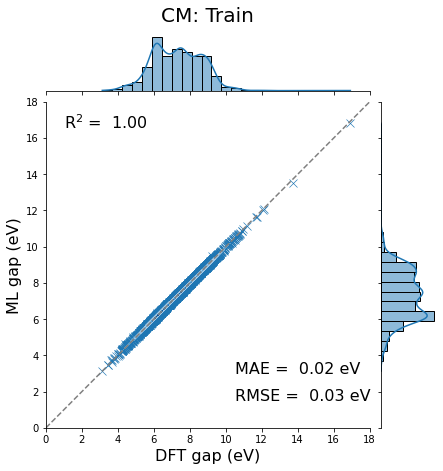

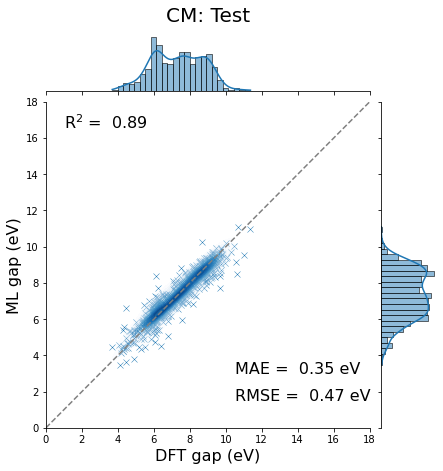

In [35]:
ax_train = sns.jointplot(x=y_cm_train,y=y_cm_train_pred,marker='x',xlim=(0,18),ylim=(0,18),s=64,marginal_kws=dict(bins=25,kde=True))
ax_test = sns.jointplot(x=y_cm_test,y=y_cm_test_pred,marker='x',xlim=(0,18),ylim=(0,18),marginal_kws=dict(bins=25,kde=True))

ax_train.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)
ax_test.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)

x0, x1 = ax_train.ax_joint.get_xlim()
lims = [max(x0, x0), min(x1, x1)]
ax_train.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)
ax_test.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)

ax_train.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)
ax_train.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)

ax_test.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)
ax_test.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)

ax_train.ax_joint.text(s=r'R$^2$ ='+f' {r2_cm_train: .2f}',x=1,y=16.5,fontsize=16)
ax_train.ax_joint.text(s=r'MAE ='+f' {mae_cm_train: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_train.ax_joint.text(s=r'RMSE ='+f' {rmse_cm_train: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_test.ax_joint.text(s=r'R$^2$ ='+f' {r2_cm_test: .2f}',x=1,y=16.5,fontsize=16)
ax_test.ax_joint.text(s=r'MAE ='+f' {mae_cm_test: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_test.ax_joint.text(s=r'RMSE ='+f' {rmse_cm_test: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_train.fig.savefig('results_cm_train.png',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_cm_test.png',dpi=600,bbox_inches='tight')

ax_train.fig.savefig('results_cm_train.pdf',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_cm_test.pdf',dpi=600,bbox_inches='tight')

ax_train.ax_joint.set_title('CM: Train',fontsize=20,pad=80,loc='center')
ax_test.ax_joint.set_title('CM: Test',fontsize=20,pad=80,loc='center')

plt.show()

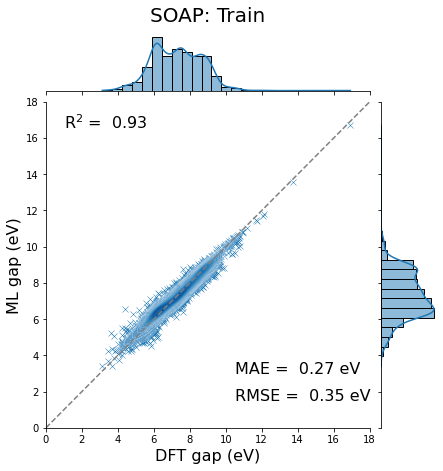

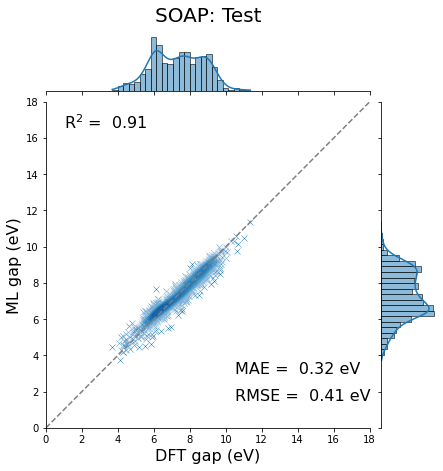

In [36]:
ax_train = sns.jointplot(x=y_soap_train,y=y_soap_train_pred,marker='x',xlim=(0,18),ylim=(0,18),marginal_kws=dict(bins=25,kde=True))
ax_test = sns.jointplot(x=y_soap_test,y=y_soap_test_pred,marker='x',xlim=(0,18),ylim=(0,18),marginal_kws=dict(bins=25,kde=True))

ax_train.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)
ax_test.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)

x0, x1 = ax_train.ax_joint.get_xlim()
lims = [max(x0, x0), min(x1, x1)]
ax_train.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)
ax_test.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)

ax_train.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)
ax_train.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)

ax_test.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)
ax_test.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)

ax_train.ax_joint.text(s=r'R$^2$ ='+f' {r2_soap_train: .2f}',x=1,y=16.5,fontsize=16)
ax_train.ax_joint.text(s=r'MAE ='+f' {mae_soap_train: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_train.ax_joint.text(s=r'RMSE ='+f' {rmse_soap_train: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_test.ax_joint.text(s=r'R$^2$ ='+f' {r2_soap_test: .2f}',x=1,y=16.5,fontsize=16)
ax_test.ax_joint.text(s=r'MAE ='+f' {mae_soap_test: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_test.ax_joint.text(s=r'RMSE ='+f' {rmse_soap_test: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_train.fig.savefig('results_soap_train.png',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_soap_test.png',dpi=600,bbox_inches='tight')

ax_train.fig.savefig('results_soap_train.pdf',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_soap_test.pdf',dpi=600,bbox_inches='tight')

ax_train.ax_joint.set_title('SOAP: Train',fontsize=20,pad=80,loc='center')
ax_test.ax_joint.set_title('SOAP: Test',fontsize=20,pad=80,loc='center')

plt.show()

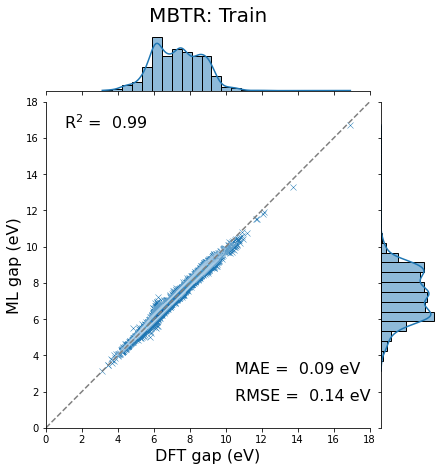

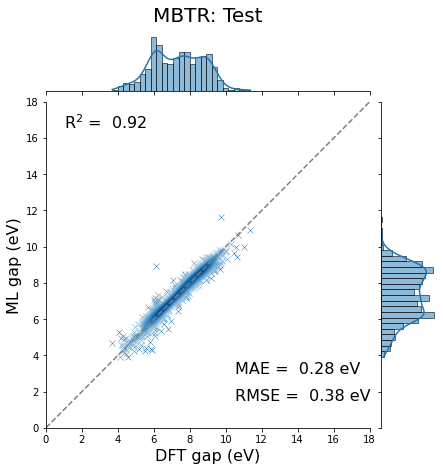

In [37]:
ax_train = sns.jointplot(x=y_mbtr_train,y=y_mbtr_train_pred,marker='x',xlim=(0,18),ylim=(0,18),marginal_kws=dict(bins=25,kde=True))
ax_test = sns.jointplot(x=y_mbtr_test,y=y_mbtr_test_pred,marker='x',xlim=(0,18),ylim=(0,18),marginal_kws=dict(bins=25,kde=True))

ax_train.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)
ax_test.plot_joint(sns.kdeplot,cmap=plt.cm.Blues,fill=True,shade=True,levels=20,alpha=0.3)

x0, x1 = ax_train.ax_joint.get_xlim()
lims = [max(x0, x0), min(x1, x1)]
ax_train.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)
ax_test.ax_joint.plot(lims, lims, c='gray',ls='--',zorder=1)

ax_train.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)
ax_train.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)

ax_test.ax_joint.set_ylabel('ML gap (eV)',fontsize=16)
ax_test.ax_joint.set_xlabel('DFT gap (eV)',fontsize=16)

ax_train.ax_joint.text(s=r'R$^2$ ='+f' {r2_mbtr_train: .2f}',x=1,y=16.5,fontsize=16)
ax_train.ax_joint.text(s=r'MAE ='+f' {mae_mbtr_train: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_train.ax_joint.text(s=r'RMSE ='+f' {rmse_mbtr_train: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_test.ax_joint.text(s=r'R$^2$ ='+f' {r2_mbtr_test: .2f}',x=1,y=16.5,fontsize=16)
ax_test.ax_joint.text(s=r'MAE ='+f' {mae_mbtr_test: .2f} eV',x=10.5,y=3.,fontsize=16)
ax_test.ax_joint.text(s=r'RMSE ='+f' {rmse_mbtr_test: .2f} eV',x=10.5,y=1.5,fontsize=16)

ax_train.fig.savefig('results_mbtr_train.png',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_mbtr_test.png',dpi=600,bbox_inches='tight')

ax_train.fig.savefig('results_mbtr_train.pdf',dpi=600,bbox_inches='tight')
ax_test.fig.savefig('results_mbtr_test.pdf',dpi=600,bbox_inches='tight')

ax_train.ax_joint.set_title('MBTR: Train',fontsize=20,pad=80,loc='center')
ax_test.ax_joint.set_title('MBTR: Test',fontsize=20,pad=80,loc='center')

plt.show()

### Learning curves

In [38]:
cm_train_sizes, cm_train_scores, cm_test_scores = learning_curve(krr_cm, coulomb_matrices, y_true, cv=5, n_jobs=2,train_sizes=np.linspace(.1, 1.0, 5),scoring="neg_mean_absolute_error")

In [39]:
cm_train_scores_mean = np.mean(-cm_train_scores, axis=1)
cm_train_scores_std = np.std(-cm_train_scores, axis=1)
cm_test_scores_mean = np.mean(-cm_test_scores, axis=1)
cm_test_scores_std = np.std(-cm_test_scores, axis=1)

In [40]:
soap_train_sizes, soap_train_scores, soap_test_scores = learning_curve(krr_soap, soap_descriptors, y_true, cv=5, n_jobs=2,train_sizes=np.linspace(.1, 1.0, 5),scoring="neg_mean_absolute_error")

In [41]:
soap_train_scores_mean = np.mean(-soap_train_scores, axis=1)
soap_train_scores_std = np.std(-soap_train_scores, axis=1)
soap_test_scores_mean = np.mean(-soap_test_scores, axis=1)
soap_test_scores_std = np.std(-soap_test_scores, axis=1)

In [42]:
mbtr_train_sizes, mbtr_train_scores, mbtr_test_scores = learning_curve(krr_mbtr, mbtr_descriptors, y_true, cv=5, n_jobs=2,train_sizes=np.linspace(.1, 1.0, 5),scoring="neg_mean_absolute_error")

In [43]:
mbtr_train_scores_mean = np.mean(-mbtr_train_scores, axis=1)
mbtr_train_scores_std = np.std(-mbtr_train_scores, axis=1)
mbtr_test_scores_mean = np.mean(-mbtr_test_scores, axis=1)
mbtr_test_scores_std = np.std(-mbtr_test_scores, axis=1)

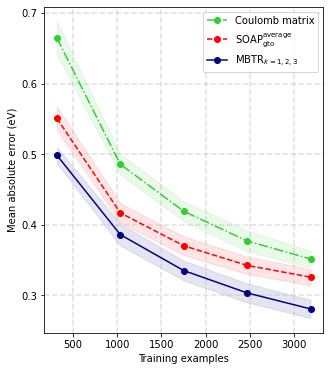

In [44]:
# Plot learning curve

fig,ax = plt.subplots(figsize=(5,6))

ax.grid()
ax.grid(axis='both',color='silver',ls='--',lw=1.5,alpha=0.5)

ax.fill_between(cm_train_sizes, cm_test_scores_mean - cm_test_scores_std,
                     cm_test_scores_mean + cm_test_scores_std, alpha=0.1,
                     color="limegreen")
ax.plot(cm_train_sizes, cm_test_scores_mean, 'o-.', color="limegreen",
             label="Coulomb matrix")

ax.fill_between(soap_train_sizes, soap_test_scores_mean - soap_test_scores_std,
                     soap_test_scores_mean + soap_test_scores_std, alpha=0.1,
                     color="red")
ax.plot(soap_train_sizes, soap_test_scores_mean, 'o--', color="red",
             label=r"SOAP$_{\rm gto}^{\rm average}$")

ax.fill_between(mbtr_train_sizes, mbtr_test_scores_mean - mbtr_test_scores_std,
                     mbtr_test_scores_mean + mbtr_test_scores_std, alpha=0.1,
                     color="navy")
ax.plot(mbtr_train_sizes, mbtr_test_scores_mean, 'o-', color="navy",
             label=r"MBTR$_{k=1,2,3}$")

ax.set_xlabel("Training examples")
ax.set_ylabel("Mean absolute error (eV)")

ax.legend(loc="best")

plt.savefig('learning_curve_together.pdf',format='pdf',dpi=600,bbox_inches='tight')
plt.savefig('learning_curve_together.png',format='png',dpi=600,bbox_inches='tight')

plt.show()